In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
party_the_3rd = os.path.join(parent, 'third_party')
for path_ in [parent, party_the_3rd]:
    if path_ not in (cur_path:=sys.path):
        sys.path = [path_] + cur_path
print(sys.path)


import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm

import kradagrad
import shampoo


['/home/jmei/code/experiments/kradagrad/third_party', '/home/jmei/code/experiments/kradagrad', '/home/jmei/code/experiments/kradagrad/experiments', '/home/jmei/miniconda3/envs/krad/lib/python310.zip', '/home/jmei/miniconda3/envs/krad/lib/python3.10', '/home/jmei/miniconda3/envs/krad/lib/python3.10/lib-dynload', '', '/home/jmei/miniconda3/envs/krad/lib/python3.10/site-packages']


/home/jmei/miniconda3/envs/krad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# problem sizes
X_sz = 4
Y_sz = 2
batch_sz = 32
N_tr = 1_024
N_va = 128

# model hyperparams
mlp_sizes = [X_sz, 8, 8, Y_sz]
loss_fn = torch.nn.MSELoss()

# reproducible
torch.manual_seed(4750)

# create MLP
layers = []
for i_ in range(1, len(mlp_sizes)):
    layers.append(torch.nn.Linear(mlp_sizes[i_ - 1], mlp_sizes[i_]))
    layers.append(torch.nn.Softplus())
model = torch.nn.Sequential(*layers[:-1])

#we don't really need gt params for anything:
#params_gt = list(x.detach() for x in model.parameters())

# gen data
# non-diagonal data distribution
U = torch.randn((X_sz, X_sz))
U = torch.triu(U)

X = torch.randn((N_tr+N_va, X_sz)).mm(U.T)
Y = model(X)

dataloader_tr = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[:N_tr], Y[:N_tr]), batch_size=batch_sz, shuffle=True)
dataloader_va = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X[N_tr:], Y[N_tr:]), batch_size=batch_sz, shuffle=False)

In [3]:
# re-intialize params for fair training
def reinit(model, seed):
    torch.manual_seed(seed)
    for p in model.parameters():
        with torch.no_grad():
            p.data = torch.randn_like(p)
            
# repeatable training run for different optimizers
def simple_train_run(model, loss_fn, n_it, opt, val_int, exp_name='', retain_graph=False, dataloader_tr=dataloader_tr, dataloader_va=dataloader_va):
    os.makedirs('mlp', exist_ok=True)
    tr_fn = os.path.join('mlp', '{}_loss_tr.npy'.format(exp_name))
    va_fn = os.path.join('mlp', '{}_loss_va.npy'.format(exp_name))
    if os.path.isfile(tr_fn) and os.path.isfile(va_fn):
        print('  already trained. loading: {}, {}'.format(tr_fn, va_fn))
        loss_tr, loss_va = np.load(tr_fn), np.load(va_fn)
        return loss_tr, loss_va
    n_tr = len(dataloader_tr.dataset)
    n_va = len(dataloader_va.dataset)
    model.train()
    loss_tr = []
    loss_va = []
    for it_ in tqdm(range(n_it), 'Epoch', ncols=80):
        loss_tr_this = 0
        for i_, (X_b, Y_b) in enumerate(dataloader_tr):
            Y_hat = model(X_b)
            err = loss_fn(Y_hat, Y_b)
            with torch.no_grad():
                loss_tr_this += err.item()
            opt.zero_grad()
            err.backward(retain_graph=retain_graph)
            opt.step()
        loss_tr.append(loss_tr_this / n_tr)
        
        # validation loss
        if it_ % val_int == (val_int - 1):
            model.eval()
            loss_va_this = 0
            for i_, (X_b, Y_b) in enumerate(dataloader_va):
                with torch.no_grad():
                    Y_hat = model(X_b)
                    err = loss_fn(Y_hat, Y_b)
                    loss_va_this += err.item()
            loss_va.append(loss_va_this / n_va)
            model.train()
    np.save(tr_fn, loss_tr)
    np.save(va_fn, loss_va)
    return loss_tr, loss_va

In [8]:
# common optimizer hyperparams
lr = 5e-3
seed_exp = 95054

# training settings
n_it = 640
val_int = 4
it_val = [x for x in range(n_it) if x % val_int == val_int - 1]


# Optimizers
opt_names = ['sgd', 'sgd0_9',
             'ada', 'ada0_9',
             'shampoo', 'shampoo0_99', 'shampoo0_99_graft',
             'krad', 'krad0_99', 'krad0_99_graft'
]
loss_tr = {}
loss_va = {}
hps = [shampoo.ShampooHyperParams(weight_decay=1e-6,
    matrix_eps=m_, graft_type=g_, block_size=bs_, beta2=be_
) for (m_, g_, bs_, be_) in (
    
    [1e-2, 1, np.inf, 1],     # SGD
    [1e-2, 1, np.inf, 0.9],   # SGD 0.9
    [1e-2, 2, np.inf, 1],     # Adagrad
    [1e-2, 2, np.inf, 0.9],   # Ada 0.9
    [1e-6, 0, 8, 1],          # Shampoo
    [1e-12, 0, 8, 0.99],      # Shampoo 0.99
    [1e-12, 2, 8, 0.99],      # Shampoo 0.99 adagraft

    [1e0, 0, 8, 1],           # Krad
    [1e0, 0, 8, 0.99],        # Krad 0.99
    [1e0, 2, 8, 0.99],        # Krad 0.99 adagraft
)]

classes = [shampoo.Shampoo] * 7 + [kradagrad.KradagradPP] * 3

opts = [class_(model.parameters(), lr=lr, hyperparams=hp_) for (class_, hp_) in zip(classes, hps)]

for opt_name_, opt_ in zip(opt_names, opts):
    print('Using {}'.format(opt_name_))
    reinit(model, seed_exp)
    # `retain_graph` still required for some reason... haven't figured out why
    loss_tr_, loss_va_ = simple_train_run(model, loss_fn, n_it, opt_, val_int, exp_name=opt_name_, retain_graph=True)
    loss_tr[opt_name_] = loss_tr_
    loss_va[opt_name_] = loss_va_


Using sgd
  already trained. loading: mlp/sgd_loss_tr.npy, mlp/sgd_loss_va.npy
Using sgd0_9
  already trained. loading: mlp/sgd0_9_loss_tr.npy, mlp/sgd0_9_loss_va.npy
Using ada
  already trained. loading: mlp/ada_loss_tr.npy, mlp/ada_loss_va.npy
Using ada0_9
  already trained. loading: mlp/ada0_9_loss_tr.npy, mlp/ada0_9_loss_va.npy
Using shampoo
  already trained. loading: mlp/shampoo_loss_tr.npy, mlp/shampoo_loss_va.npy
Using shampoo0_99
  already trained. loading: mlp/shampoo0_99_loss_tr.npy, mlp/shampoo0_99_loss_va.npy
Using shampoo0_99_graft
  already trained. loading: mlp/shampoo0_99_graft_loss_tr.npy, mlp/shampoo0_99_graft_loss_va.npy
Using krad


Epoch:  56%|███████████████████▏              | 361/640 [00:40<00:30,  9.15it/s]

0 11520 tensor(0.9826)
1 11520 tensor(1.0978)
0 11520 tensor(0.7312)
1 11520 tensor(0.9947)
0 11520 tensor(0.0012)
1 11520 tensor(0.6392)


Epoch:  70%|███████████████████████▉          | 451/640 [00:50<00:21,  8.81it/s]

0 14400 tensor(0.9710)
1 14400 tensor(1.0980)
0 14400 tensor(0.7139)
1 14400 tensor(0.9818)
0 14400 tensor(0.0011)
1 14400 tensor(0.6326)


Epoch:  85%|████████████████████████████▋     | 541/640 [01:00<00:10,  9.02it/s]

0 17280 tensor(0.9427)
1 17280 tensor(1.0981)
0 17280 tensor(0.6994)
1 17280 tensor(0.9697)
0 17280 tensor(0.0009)
1 17280 tensor(0.6278)


Epoch:  99%|█████████████████████████████████▌| 631/640 [01:10<00:01,  8.70it/s]

0 20160 tensor(0.8956)
1 20160 tensor(1.0982)
0 20160 tensor(0.6877)
1 20160 tensor(0.9591)
0 20160 tensor(0.0006)
1 20160 tensor(0.6237)


Epoch: 100%|██████████████████████████████████| 640/640 [01:11<00:00,  9.00it/s]

Using krad0_99
  already trained. loading: mlp/krad0_99_loss_tr.npy, mlp/krad0_99_loss_va.npy
Using krad0_99_graft
  already trained. loading: mlp/krad0_99_graft_loss_tr.npy, mlp/krad0_99_graft_loss_va.npy


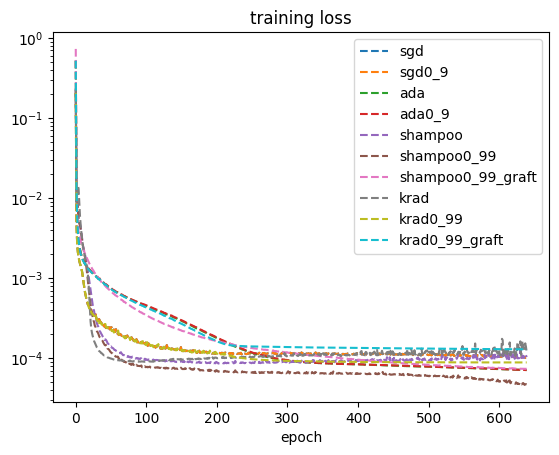

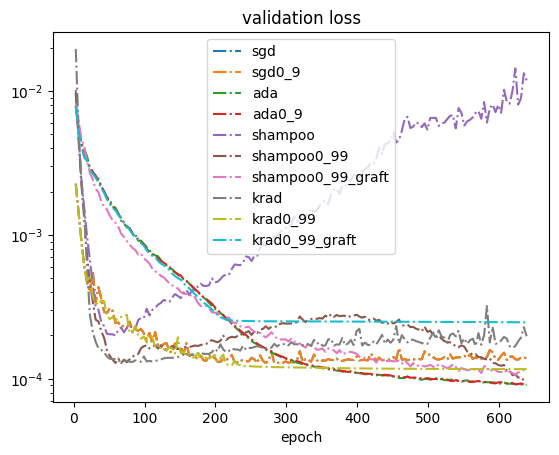

In [9]:
plt.figure()
for opt_name_ in opt_names:
    plt.semilogy(range(n_it), loss_tr[opt_name_], '--')
plt.legend(opt_names)
plt.xlabel('epoch')
plt.title('training loss')

plt.figure()
for opt_name_ in opt_names:
    plt.semilogy(it_val, loss_va[opt_name_], '-.')
plt.legend(opt_names)
plt.xlabel('epoch')
plt.title('validation loss')

plt.show()

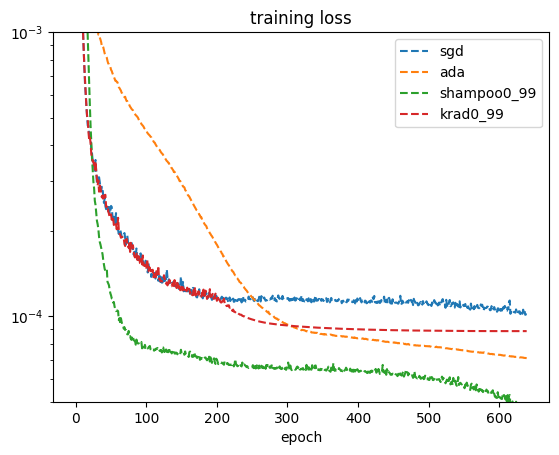

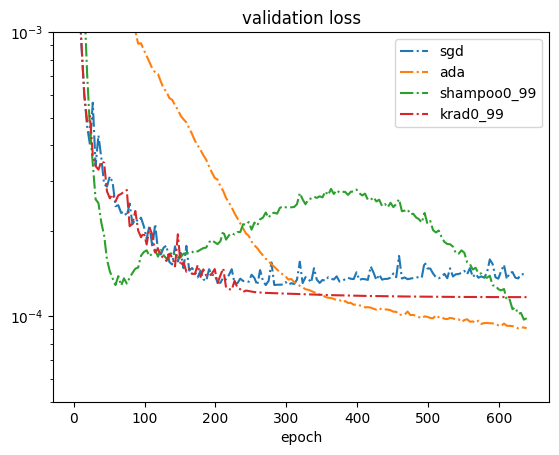

In [15]:
compare_names = ['sgd', 'ada', 'shampoo0_99', 'krad0_99']

plt.figure()
for opt_name_ in compare_names:
    plt.semilogy(range(n_it), loss_tr[opt_name_], '--')
plt.legend(compare_names)
plt.ylim([5e-5,1e-3])
plt.xlabel('epoch')
plt.title('training loss')

plt.figure()
for opt_name_ in compare_names:
    plt.semilogy(it_val, loss_va[opt_name_], '-.')
plt.legend(compare_names)
plt.ylim([5e-5,1e-3])
plt.xlabel('epoch')
plt.title('validation loss')

plt.show()